## **Aplicando modelo Regressão Linear Simples**

In [1]:
## confirgurando diretório
import os
os.chdir("..")

## importando bibliotecas
import warnings 
import pandas as pd
import numpy as np
import holidays
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from main.evaluation import Evaluation
from main.plots import plot_hist
from main.plots import plot_time_series
from matplotlib import pyplot as plt

## configurando notebook
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%load_ext autoreload
%autoreload 2

## **Leitura dos Dados**

In [2]:
## leitura dos dados
train_df = pd.read_csv("nbs/data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("nbs/data/test_df.csv", parse_dates=['ds'])

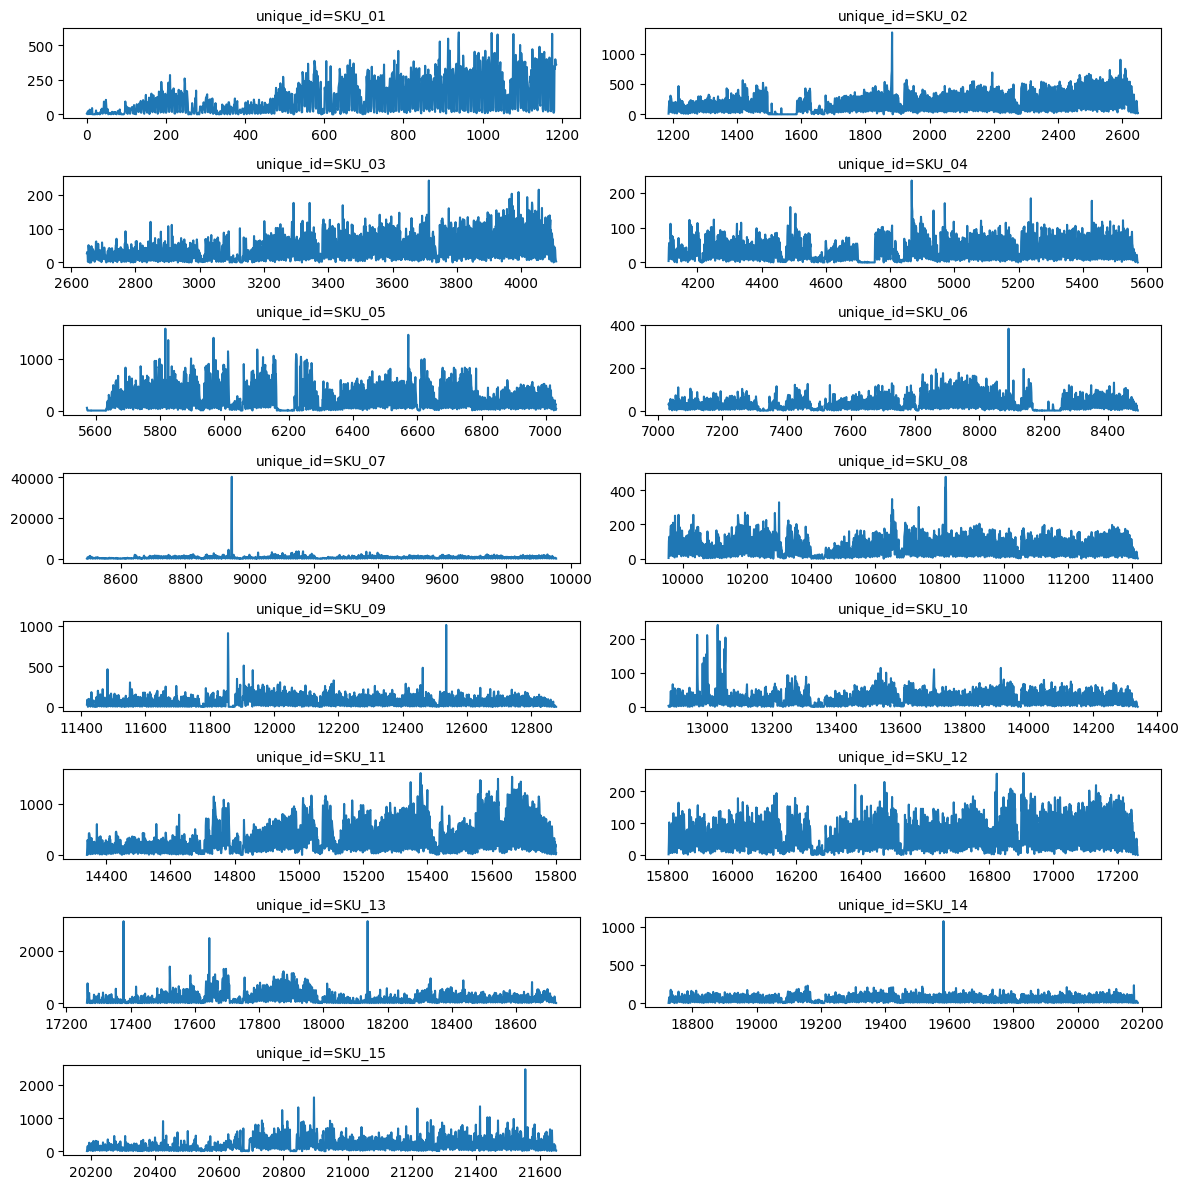

In [3]:
## visualizando dados de treino
plot_time_series(df=train_df, data_cols=['y'], figsize=(12,12))

## **Regressão Linear Simples**
Uma abordagem do modelo de regressão linear aplicado a séries temporais pode ser visto em [Forecasting: Principles and Practice (3rd ed) - The linear model](https://otexts.com/fpp3/regression-intro.html)

In [4]:
def linear_regression(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo simples de regressão linear. Usa a ordem t como regressor.
    """    
    train = df.copy().reset_index(drop=True)
    unique_id = train.unique_id[0]
    test = test_df[test_df['unique_id'] == unique_id].reset_index(drop=True)
    test.index = test.index + train.index.max()  # atualiza o index da série de teste para regressão

    m = LinearRegression()
    m.fit(
        X=train.index.values.reshape(-1,1), 
        y=train.y
    )
    test['predicted'] = m.predict(X=test.index.values.reshape(-1,1))

    return test

In [5]:
## aplicando modelo para cada série
fcst_df = train_df.groupby("unique_id").apply(linear_regression).reset_index(drop=True)

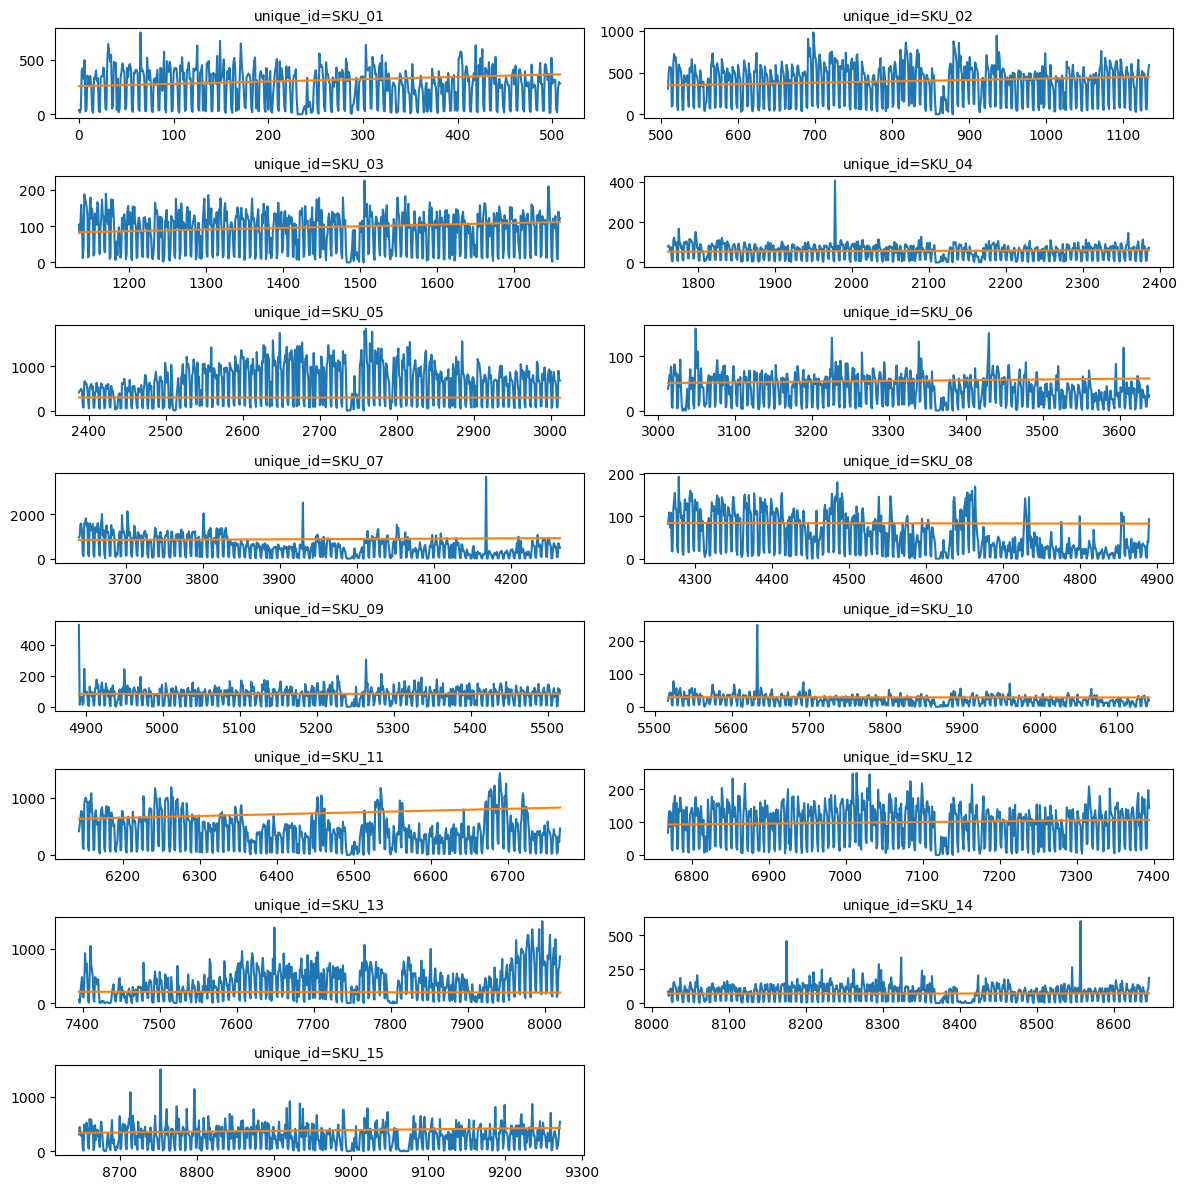

In [7]:
## plot das previsões 
plot_time_series(df=fcst_df, data_cols=['y', 'predicted'], figsize=(12,12))

In [8]:
## métricas de desempenho
f = lambda x: Evaluation(x['y'], x['predicted']).summary()
fcst_df.groupby("unique_id").apply(f)

,,MAE,MSE,RMSE,R2
unique_id,,,,,
SKU_01,0,155.87,35460.10,188.31,-0.16
SKU_02,0,195.17,53654.73,231.63,-0.03
SKU_03,0,45.89,3087.54,55.57,-0.07
SKU_04,0,31.00,1454.88,38.14,-0.02
SKU_05,0,462.15,301882.66,549.44,-0.58
SKU_06,0,26.08,1027.54,32.06,-0.41
SKU_07,0,503.39,347957.47,589.88,-0.53
SKU_08,0,49.37,3081.35,55.51,-0.38
SKU_09,0,42.67,3022.21,54.97,-0.03


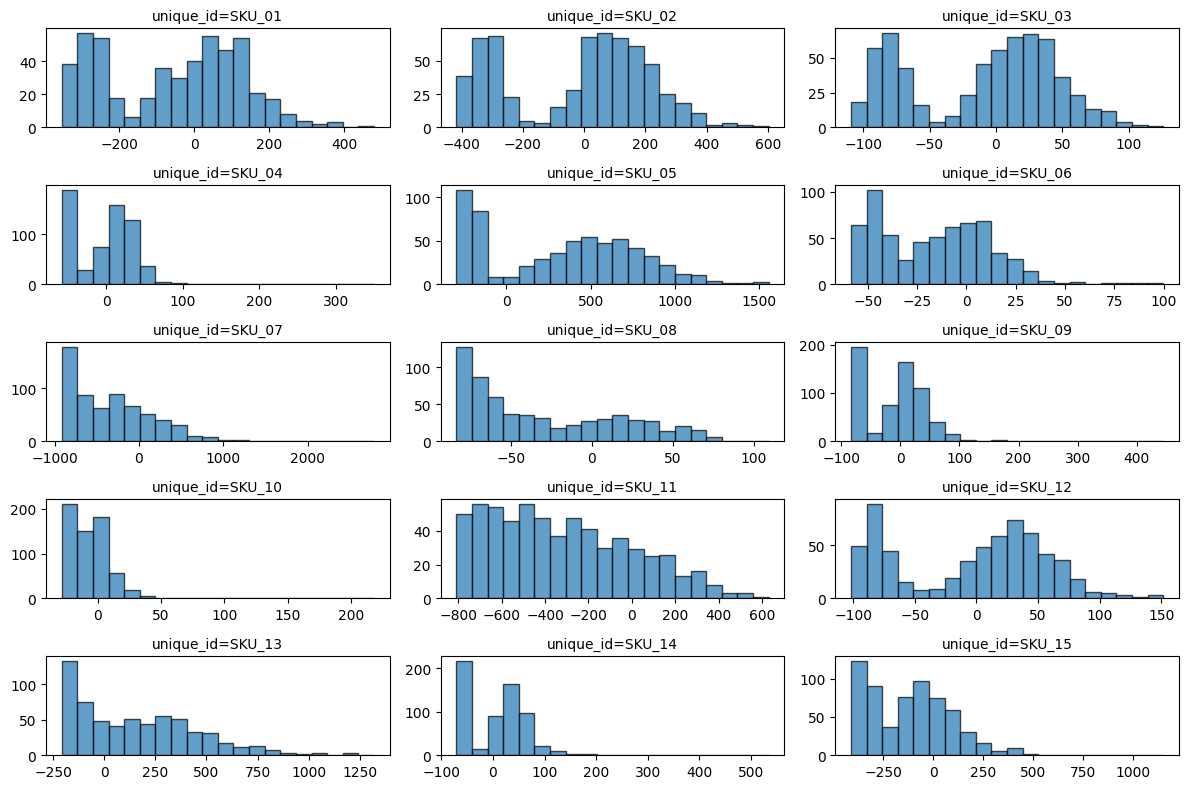

In [12]:
## plot dos resíduos do modelo
plot_hist(
    df=fcst_df.assign(residual = lambda x: x['y'] - x['predicted']),
    id_col='unique_id',
    data_col=['residual'],
    ids=fcst_df.unique_id.unique(),
    grid=(5, 3),
    figsize=(12,8)
)

## **Engenharia de Características**
Acrescentaremos algumas features para tentar captar a sazonalidade no modelo de regressão linear múltipla.

In [21]:
def dia_util(day : str) -> int:
    """Valida se uma data é feriado nacional.

    Args:
        day (str): Dia para validação.

    Returns:
        int: Interio binário. 1 (sim) ou 0 (não).
    """
    day = pd.to_datetime(day)
    feriados_br = holidays.country_holidays('BR')
    dias_semana = [5, 6]
    
    if (day in feriados_br) | (day.day_of_week in dias_semana):
        return 0
    return 1


def add_features(
        df : pd.DataFrame, 
        time_col : str = 'ds'
) -> pd.DataFrame:
    """Adiciona features de calendário ao dataframe com base na coluna de data.

    Args:
        df (_type_): _description_

    Returns:
        _type_: _description_
    """
    # adicionar semana no mês 
    # adicionar semana no ano
    df['dia_util'] = df[time_col].apply(dia_util)
    df['day'] = df[time_col].dt.day_of_year
    df['year'] = df[time_col].dt.year
    df['quarter'] = df[time_col].dt.quarter
    return df


In [ ]:
# TODO: 
# Fazer previsão com os regressores
# testar crossvalidation
# usar SARIMA para avaliar